Loaded 400000 word vectors!

=== Trial 1 ===
Ξ shape: (50, 50)
Started from noisy 'public-access' — converged closest to: 'public-access'
Started from noisy 'latv' — converged closest to: 'kōzuke'
Started from noisy '1,038' — converged closest to: 'taft-hartley'
Started from noisy 'taft-hartley' — converged closest to: 'taft-hartley'
Started from noisy 'bekmambetov' — converged closest to: 'bekmambetov'
Started from noisy 'lascar' — converged closest to: 'lascar'
Started from noisy 'a-mano' — converged closest to: 'a-mano'
Started from noisy 'bramwell' — converged closest to: 'tranghese'
Started from noisy 'balerno' — converged closest to: 'lendale'
Started from noisy 'kutz' — converged closest to: 'kutz'
Started from noisy 'dominations' — converged closest to: 'kōzuke'
Started from noisy 'linolenic' — converged closest to: 'linolenic'
Started from noisy 'cheslatta' — converged closest to: 'cheslatta'
Started from noisy 'kōzuke' — converged closest to: 'kōzuke'
Started from noisy '8.19

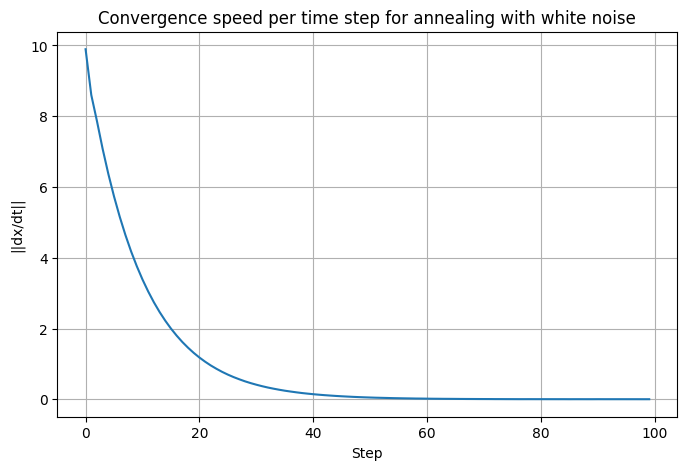

C:\Users\hhl222\AppData\Local\Temp\ipykernel_3632\2002855860.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


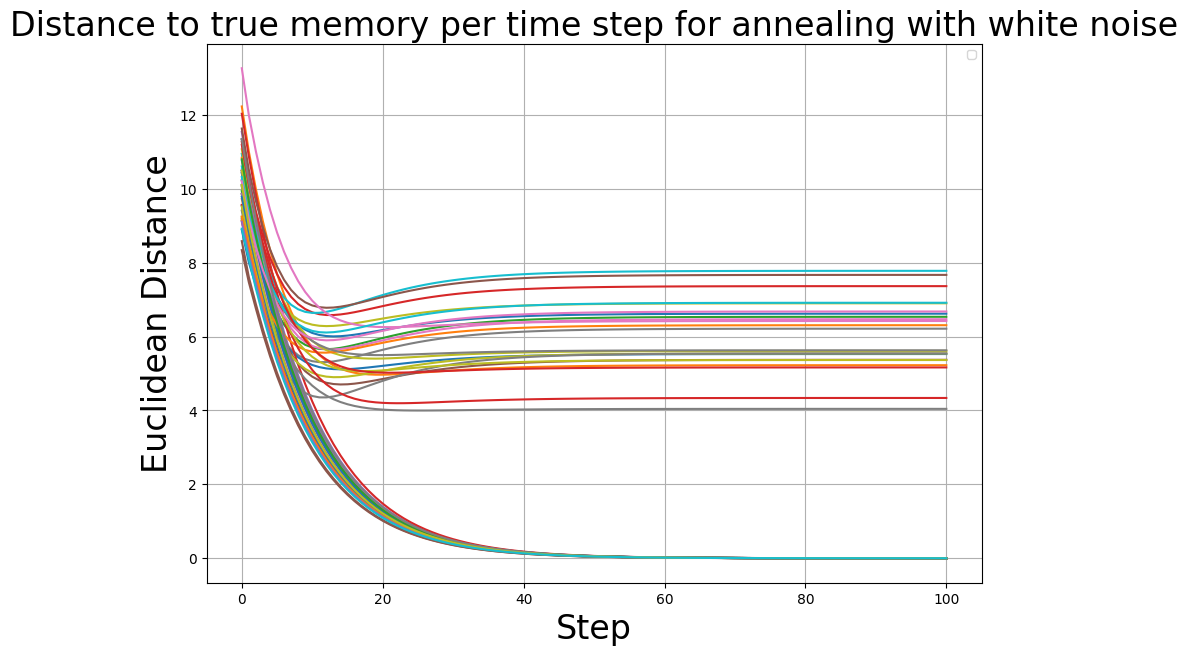

C:\Users\hhl222\AppData\Local\Temp\ipykernel_3632\2002855860.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', K)
C:\Users\hhl222\AppData\Local\Temp\ipykernel_3632\2002855860.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small', ncol=2)


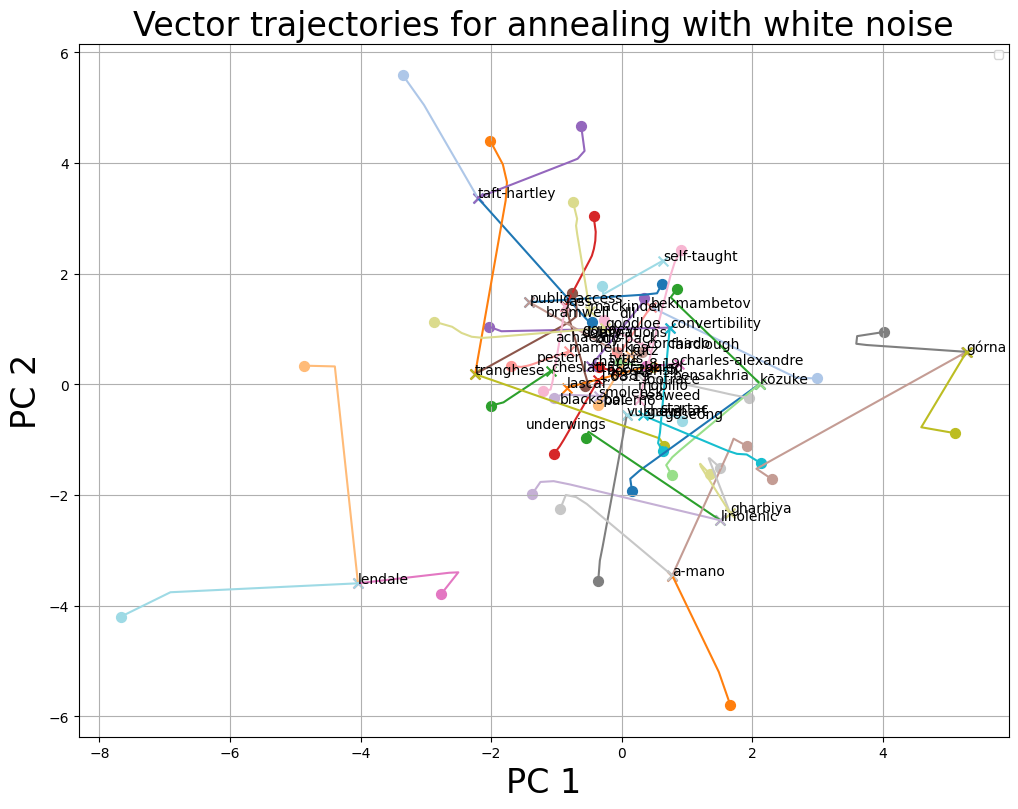

C:\Users\hhl222\AppData\Local\Temp\ipykernel_3632\2002855860.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


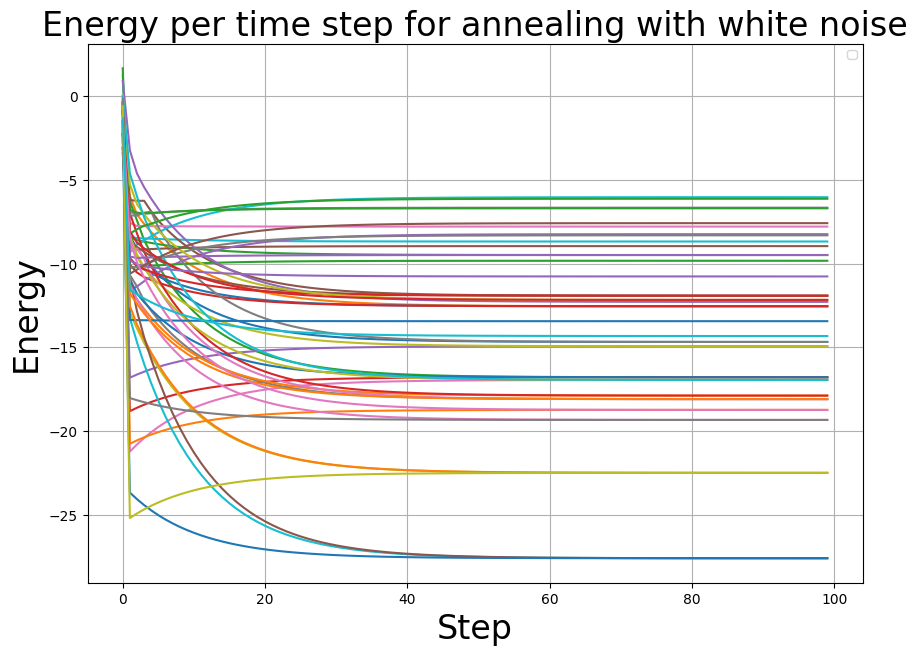


=== Trial 2 ===
Ξ shape: (50, 50)
Started from noisy 'abaroa' — converged closest to: 'lala'
Started from noisy 'akcr' — converged closest to: 'soewardi'
Started from noisy 'vitex' — converged closest to: 'unring'
Started from noisy 'maffra' — converged closest to: 'maffra'
Started from noisy 'gnomon' — converged closest to: 'nf6'
Started from noisy 'leonese' — converged closest to: 'deadpan'
Started from noisy 'misdiagnosing' — converged closest to: 'misdiagnosing'
Started from noisy 'carrigan' — converged closest to: 'jh'
Started from noisy 'reprocessed' — converged closest to: 'reprocessed'
Started from noisy 'deadpan' — converged closest to: 'deadpan'
Started from noisy 'priapism' — converged closest to: '7103'
Started from noisy 'charness' — converged closest to: 'charness'
Started from noisy 'bullen' — converged closest to: 'inside-forward'
Started from noisy 'didache' — converged closest to: 'müller-ury'
Started from noisy 'blagojevich' — converged closest to: 'blagojevich'
Sta

In [29]:
#Load dataset
import numpy as np
import matplotlib.pyplot as plt

# Path to your local GloVe file
glove_path = 'C:\\Users\\hhl222\\Downloads\\glove.6B.50d.txt'

# Dictionary to store word -> vector mapping
word_vectors = {}

# Read the file
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        word_vectors[word] = vector

print(f"Loaded {len(word_vectors)} word vectors!")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import random

# === Softmax function ===
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

# === Annealing Hopfield network evolution with Euler-Maruyama noise ===
def anneal_hopfield_euler_maruyama(
    Xi, initial_x, w, steps=100, beta_max=100, dt=0.1, sigma_noise=1e-4
):
    N = Xi.shape[1]

    x = initial_x.copy()
    trajectory = [x.copy()]
    energy = []

    for t in range(steps):
        beta = beta_max * (t / steps)
        logits = beta * (Xi @ x) + beta * w
        p = softmax(logits)

        x_dot = Xi.T @ p - x
        noise = sigma_noise * np.sqrt(dt) * np.random.randn(N)

        x_new = x + dt * x_dot + noise
        trajectory.append(x_new.copy())

        energy_step = -0.5 * x_new @ (Xi.T @ p) - w @ x_new
        energy.append(energy_step)

        x = x_new

    return np.array(trajectory), np.array(energy)

# === Find closest stored word by cosine similarity ===
def find_closest(x, Xi, word_list):
    sims = (Xi @ x) / (np.linalg.norm(Xi, axis=1) * np.linalg.norm(x) + 1e-8)
    idx = np.argmax(sims)
    return word_list[idx]

# === Run annealing on all words with noise ===
def run_annealing_all_words_with_noise(
    Xi, subset_words, steps=100, beta_max=100, dt=0.1,
    noise_level=1.5, sigma_noise=1e-4
):
    K, N = Xi.shape
    trajectories = []
    final_words = []
    success_count = 0
    all_distances = np.zeros((K, steps+1))
    all_energies = np.zeros((K, steps))
    w = np.zeros(N)  # zero bias

    for i in range(K):
        noisy_start = Xi[i] + noise_level * np.random.randn(N)
        #noisy_start /= np.linalg.norm(noisy_start)

        traj, energy = anneal_hopfield_euler_maruyama(
            Xi, noisy_start, w, steps=steps, beta_max=beta_max, dt=dt, sigma_noise=sigma_noise
        )
        trajectories.append(traj)
        all_energies[i, :] = energy

        for t in range(traj.shape[0]):
            all_distances[i, t] = np.linalg.norm(traj[t] - Xi[i])

        final_x = traj[-1]
        closest_word = find_closest(final_x, Xi, subset_words)
        final_words.append(closest_word)

        if closest_word == subset_words[i]:
            success_count += 1

        print(f"Started from noisy '{subset_words[i]}' — converged closest to: '{closest_word}'")

    success_rate = success_count / K
    print(f"\nSuccess rate: {success_rate*100:.1f}%")

    return np.array(trajectories, dtype=object), final_words, success_rate, all_distances, all_energies

# === Plot convergence speed ===
def plot_convergence_norm(trajectory, dt=0.1):
    dx_norms = [np.linalg.norm(trajectory[i+1] - trajectory[i]) / dt for i in range(len(trajectory)-1)]
    plt.figure(figsize=(8, 5))
    plt.plot(dx_norms)
    plt.xlabel('Step')
    plt.ylabel('||dx/dt||')
    plt.title('Convergence speed per time step for annealing with white noise')
    plt.grid(True)
    plt.show()

# === Plot Euclidean distance over time ===
def plot_euclidean_distances(all_distances, subset_words, word_indices=None):
    plt.figure(figsize=(10, 7))
    time = np.arange(all_distances.shape[1])
    if word_indices is None:
        word_indices = range(len(subset_words))

    for i in word_indices:
        plt.plot(time, all_distances[i])

    plt.xlabel("Step", fontsize=24)
    plt.ylabel("Euclidean Distance", fontsize=24)
    plt.title("Distance to true memory per time step for annealing with white noise", fontsize=24)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()

# === Plot trajectories projected to 2D PCA, start = circle, end = cross ===
def plot_trajectories_with_targets(all_trajectories, Xi, subset_words):
    all_points = np.vstack([traj for traj in all_trajectories if traj.shape[0] > 0])
    pca = PCA(n_components=2)
    all_points_2d = pca.fit_transform(all_points)

    trajectories_2d = []
    start = 0
    for traj in all_trajectories:
        end = start + traj.shape[0]
        trajectories_2d.append(all_points_2d[start:end])
        start = end

    plt.figure(figsize=(12, 9))

    K = len(all_trajectories)
    colors = cm.get_cmap('tab20', K)

    for idx, traj_2d in enumerate(trajectories_2d):
        c = colors(idx)
        plt.plot(traj_2d[:, 0], traj_2d[:, 1], color=c)
        plt.scatter(traj_2d[0, 0], traj_2d[0, 1], c=[c], marker='o', s=50)  # start circle
        plt.scatter(traj_2d[-1, 0], traj_2d[-1, 1], c=[c], marker='x', s=50) # end cross

    memories_2d = pca.transform(Xi)

    for i, word in enumerate(subset_words):
        plt.annotate(word, (memories_2d[i, 0], memories_2d[i, 1]), fontsize=10, color='black')

    plt.xlabel('PC 1', fontsize=24)
    plt.ylabel('PC 2', fontsize=24)
    plt.title('Vector trajectories for annealing with white noise', fontsize=24)
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.grid(True)
    plt.show()

# === Plot energy over time ===
def plot_energy(all_energies, subset_words, word_indices=None):
    plt.figure(figsize=(10, 7))
    time = np.arange(all_energies.shape[1])
    if word_indices is None:
        word_indices = range(len(subset_words))

    for i in word_indices:
        plt.plot(time, all_energies[i])

    plt.xlabel("Step", fontsize=24)
    plt.ylabel("Energy", fontsize=24)
    plt.title("Energy per time step for annealing with white noise", fontsize=24)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()

# === Run 10 trials of the annealing process ===
num_trials = 10
all_trials_results = []

for trial in range(num_trials):
    print(f"\n=== Trial {trial+1} ===")
    # Sample 50 words randomly for this trial
    all_words = list(word_vectors.keys())
    subset_words = random.sample(all_words, 50)
    Xi = np.stack([word_vectors[word] for word in subset_words])
    print(f"Ξ shape: {Xi.shape}")  # Should be (50, 50)

    trajectories, final_words, success_rate, all_distances, all_energies = run_annealing_all_words_with_noise(
        Xi, subset_words, steps=100, beta_max=100, dt=0.1,
        noise_level=1.5, sigma_noise=1e-4
    )
    all_trials_results.append({
        'trajectories': trajectories,
        'final_words': final_words,
        'success_rate': success_rate,
        'all_distances': all_distances,
        'all_energies': all_energies
    })

    # Plot for the first trajectory only for brevity
    if trial == 0:
        plot_convergence_norm(trajectories[0], dt=0.1)
        plot_euclidean_distances(all_distances, subset_words)
        plot_trajectories_with_targets(trajectories, Xi, subset_words)
        plot_energy(all_energies, subset_words)
    
avg_success_rate = np.mean([res['success_rate'] for res in all_trials_results])
print(f"\nAverage success rate over 10 runs: {avg_success_rate*100:.2f}%")
